# **Dataset 2**

### **Import Packages**

In [1]:
import multiprocessing
import subprocess
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import sys

sys.path.append(os.path.abspath("../src"))

from generation.data_synthesizer import ds_generate_data
from generation.synthetic_data_vault import sdv_generate_data
from evaluation.utility import run_utility_eval
from evaluation.resemblance import pairwise_correlation_diff, jsd, wd
from evaluation.privacy import dcr, nndr, mia
from sklearn.preprocessing import LabelEncoder

### **Exploratory Data Analysis**

In [2]:
# Load the dataset as dataframe
data_path = "../data/original_data/2_fictional_students_performance/2_fictional_students_performance.csv"
original_data = pd.read_csv(data_path)
original_data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
# Get general information about the dataset
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [4]:
# Check for missing values
original_data.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [5]:
# Check number of unique values in each column
original_data.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     81
reading score                  72
writing score                  77
dtype: int64

In [6]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

gender ['female' 'male']
race/ethnicity ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch ['standard' 'free/reduced']
test preparation course ['none' 'completed']


### **Synthetic Data Generation**

In [10]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

# Number of samples to generate
n = 5000

original_data_path = "../data/original_data/2_fictional_students_performance/"
train_file = os.path.join(original_data_path, "train_data.csv")
test_file = os.path.join(original_data_path, "test_data.csv")

if os.path.isfile(train_file) and os.path.isfile(test_file):
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    print("Train and test data loaded.")
else:
    # Split the data into train and test sets (70% train, 30% test) according to evaluation paper
    train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
    train_data.to_csv(train_file, index=False)
    test_data.to_csv(test_file, index=False)
    print("Train and test data saved.")

Train and test data loaded.


In [11]:
synth_path = "../data/synthetic_data/2_fictional_students_performance/"
csv_files = [file for file in os.listdir(synth_path) if file.endswith(".csv")]
dataset_name = '2_fictional_students_performance'

if len(csv_files) == 0:

    # Use train_data.csv to fit SDG models and generate synthetic data
    data_path = original_data_path + "train_data.csv"
    arguments = [data_path, str(n), dataset_name]

    print("Sampling synthpop...")
    result = subprocess.run(['Rscript', '../src/generation/synthpop.R',   *arguments], capture_output=True, text=True)

    print("Sampling DataSynthesizer...")
    ds_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)

    sdv_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)
else:
    print("Synthetic data already exists.")

Sampling synthpop...
Sampling DataSynthesizer...
================ Constructing Bayesian Network (BN) ================
Adding ROOT reading score
Adding attribute writing score
Adding attribute math score
Adding attribute parental level of education
Adding attribute race/ethnicity
Adding attribute lunch
Adding attribute test preparation course
Adding attribute gender
========================== BN constructed ==========================
Fitting copula_gan...

Time taken to fit copula_gan: 8.89 seconds

Fitting ctgan...

Time taken to fit ctgan: 6.87 seconds

Fitting tvae...

Time taken to fit tvae: 4.36 seconds

Fitting gaussian_copula...

Time taken to fit gaussian_copula: 0.19 seconds



Encode all categorical columns of both original (train+test) data and synthetic data using label encoding

In [12]:
# Load the synthetic data as dataframe
synthpop = pd.read_csv(synth_path + "synthpop.csv")
ds = pd.read_csv(synth_path + "ds.csv")
tvae = pd.read_csv(synth_path + "tvae.csv")
gaussian_copula = pd.read_csv(synth_path + "gaussian_copula.csv")
copula_gan = pd.read_csv(synth_path + "copula_gan.csv")
ctgan = pd.read_csv(synth_path + "ctgan.csv")

# Encode categorical columns as integers
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le

In [13]:
train_data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,1,3,0,0,0,79,82,80
1,0,2,4,1,0,67,81,79
2,1,2,4,0,1,68,68,61
3,0,3,3,0,0,47,58,67
4,0,0,4,1,0,72,79,82


### **Utility Evaluation**

Prepare utility evaluation

In [14]:
# Set the target column
target_col = "result"

# Prepare datasets for utility evalutation
synth_datasets = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]

# Add a column for average of math, reading and writing scores for each dataset and cut the values into three classes: fail, pass, top (0, 1, 2)
for synth_dataset in synth_datasets:
    synth_dataset['result'] = synth_dataset[['math score', 'reading score', 'writing score']].mean(axis=1)
    synth_dataset['result'] = pd.cut(synth_dataset['result'], bins=[0, 50, 80, 100], labels=[0, 1, 2])
    synth_dataset.drop(['math score', 'reading score', 'writing score'], axis=1, inplace=True)

train_data['result'] = train_data[['math score', 'reading score', 'writing score']].mean(axis=1)
train_data['result'] = pd.cut(train_data['result'], bins=[0, 50, 80, 100], labels=[0, 1, 2])
train_data.drop(['math score', 'reading score', 'writing score'], axis=1, inplace=True)
test_data['result'] = test_data[['math score', 'reading score', 'writing score']].mean(axis=1)
test_data['result'] = pd.cut(test_data['result'], bins=[0, 50, 80, 100], labels=[0, 1, 2])
test_data.drop(['math score', 'reading score', 'writing score'], axis=1, inplace=True)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,result
0,1,3,0,0,0,2
1,0,2,4,1,0,1
2,1,2,4,0,1,1
3,0,3,3,0,0,1
4,0,0,4,1,0,1


In [15]:
synthpop.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,result
0,0,3,4,0,1,1
1,0,0,0,1,1,1
2,0,4,1,1,0,2
3,0,2,5,0,1,1
4,1,1,4,0,0,1


In [16]:
train_data.nunique()

gender                         2
race/ethnicity                 5
parental level of education    6
lunch                          2
test preparation course        2
result                         3
dtype: int64

Run random forest classifier for utility evaluation

In [27]:
rf_results = {}
rf_df = pd.read_csv("../data/results/tables/rf.csv")
rows = []

if (rf_df["Dataset"] == 2).any():
    print("Entry for '2_fictional_students' already exists")
else:
    # Run utility evaluation using random forest for each synthetic dataset
    for i, synth_dataset in enumerate(synth_datasets):
        rf_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "random_forest")

        acc_diff = rf_results[model_names[i]]["acc_diff"]
        f1_diff = rf_results[model_names[i]]["f1_diff"]
        roc_auc_diff = rf_results[model_names[i]]["roc_auc_diff"]

        rows.append([2, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=rf_df.columns)
    rf_df = pd.concat([rf_df, rows])
    rf_df.to_csv("../data/results/tables/rf.csv", index=False)
    rf_df.head()

Entry for '2_fictional_students' already exists


Run logistic regression for utility evaluation

In [29]:
lr_results = {}
lr_df = pd.read_csv("../data/results/tables/lr.csv")
rows = []

if (lr_df["Dataset"] == 2).any():
    print("Entry for '2_fictional_students' already exists")
else:
# Run utility evaluation using logistic regression for each synthetic dataset
    for i, synth_dataset in enumerate(synth_datasets):
        lr_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "logistic_regression")

        acc_diff = lr_results[model_names[i]]["acc_diff"]
        f1_diff = lr_results[model_names[i]]["f1_diff"]
        roc_auc_diff = lr_results[model_names[i]]["roc_auc_diff"]

        rows.append([2, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=lr_df.columns)
    lr_df = pd.concat([lr_df, rows])
    lr_df.to_csv("../data/results/tables/lr.csv", index=False)
    lr_df.tail(7)


Entry for '2_fictional_students' already exists


Run multilayer perceptron (MLP)

In [30]:
mlp_results = {}
mlp_df = pd.read_csv("../data/results/tables/mlp.csv")
rows = []

if (mlp_df["Dataset"] == 2).any():
    print("Entry for '2_fictional_students' already exists")
else:
# Run utility evaluation using multilayer perceptron for each synthetic dataset
    for i, synth_dataset in enumerate(synth_datasets):
        mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "multilayer_perceptron")

        acc_diff = mlp_results[model_names[i]]["acc_diff"]
        f1_diff = mlp_results[model_names[i]]["f1_diff"]
        roc_auc_diff = mlp_results[model_names[i]]["roc_auc_diff"]

        rows.append([2, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=mlp_df.columns)
    mlp_df = pd.concat([mlp_df, rows])
    mlp_df.to_csv("../data/results/tables/mlp.csv", index=False)
    mlp_df.tail(7)

Entry for '2_fictional_students' already exists


### **Resemblance**

Run multiple resemblance metrics: Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance

- Correlation distance diff : lower values are better
- JSD in [0,1] range: lower values are better
- WD: lower values are better


**Difference in pairwise correlation:**

In [31]:
corr_diff_df = pd.read_csv("../data/results/tables/corr_diff.csv")
rows = []

if (corr_diff_df["Dataset"] == 2).any():
    print("Entry for '2_fictional_students' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = pairwise_correlation_diff(train_data, synth_dataset)
        rows.append([2,model_names[i], result])

    rows = pd.DataFrame(rows, columns=corr_diff_df.columns)
    corr_diff_df = pd.concat([corr_diff_df, rows])
    corr_diff_df.to_csv("../data/results/tables/corr_diff.csv", index=False)
    corr_diff_df.tail(7)

Entry for '2_fictional_students' already exists


**Jensen-Shannon Divergence**

In [32]:
jsd_df = pd.read_csv("../data/results/tables/jsd.csv")
rows = []

if (jsd_df["Dataset"] == 2).any():
    print("Entry for '2_fictional_students' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = jsd(train_data, synth_dataset)
        rows.append([2,model_names[i], result])

    rows = pd.DataFrame(rows, columns=jsd_df.columns)
    jsd_df = pd.concat([jsd_df, rows])
    jsd_df.to_csv("../data/results/tables/jsd.csv", index=False)
    jsd_df.tail(7)

Entry for '2_fictional_students' already exists


**Wasserstein Distance**

In [33]:
wd_df = pd.read_csv("../data/results/tables/wd.csv")
rows = []

if (wd_df["Dataset"] == 2).any():
    print("Entry for '2_fictional_students' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = wd(train_data, synth_dataset)
        rows.append([2,model_names[i],result])

    rows = pd.DataFrame(rows, columns=wd_df.columns)
    wd_df = pd.concat([wd_df, rows])
    wd_df.to_csv("../data/results/tables/wd.csv", index=False)
    wd_df.tail(7)

Entry for '2_fictional_students' already exists


### **Privacy**

Run privacy evaluation using Distance to closest Record (DCR), Nearest Neighbour Difference Ratio (NNDR) and Membership Inference Attack (MIA)

- **DCR**: a value of zero indicates that the synthetic record is an identical copy of the original
one -> leak of real information, higher values indicate more privacy

- **NNDR**: ratio is within [0,1], higher values indicate better privacy

- **MIA**: both accuracy and precision should be below 0.5 for all thresholds for strong privacy preservation

**Distance to closest record (DCR)**

In [34]:
dcr_df = pd.read_csv("../data/results/tables/dcr.csv")
rows = []

if (dcr_df["Dataset"] == 2).any():
    print("Entry for '2_fictional_students' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, save_hist=True)
        print(result)
        result_within_real = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, within="Original")
        result_within_synth = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, within="Synthetic")
        rows.append([2,model_names[i], result, result_within_real, result_within_synth])

    rows = pd.DataFrame(rows, columns=dcr_df.columns)
    dcr_df = pd.concat([dcr_df, rows])
    dcr_df.to_csv("../data/results/tables/dcr.csv", index=False)
    dcr_df.tail(7)

Entry for '2_fictional_students' already exists


**Nearest Neighbor distance ratio (NNDR)**

In [35]:
nndr_df = pd.read_csv("../data/results/tables/nndr.csv")
rows = []

if (nndr_df["Dataset"] == 2).any():
    print("Entry for '2_fictional_students' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = nndr(train_data, synth_dataset)
        result_within_real = nndr(train_data, synth_dataset, within="Original")
        result_within_synth = nndr(train_data, synth_dataset, within="Synthetic")
        rows.append([2,model_names[i], result, result_within_real, result_within_synth])

    rows = pd.DataFrame(rows, columns=nndr_df.columns)
    nndr_df = pd.concat([nndr_df, rows])
    nndr_df.to_csv("../data/results/tables/nndr.csv", index=False)
    nndr_df.tail(7) 

Entry for '2_fictional_students' already exists


**Membership Inference Attack (MIA)**

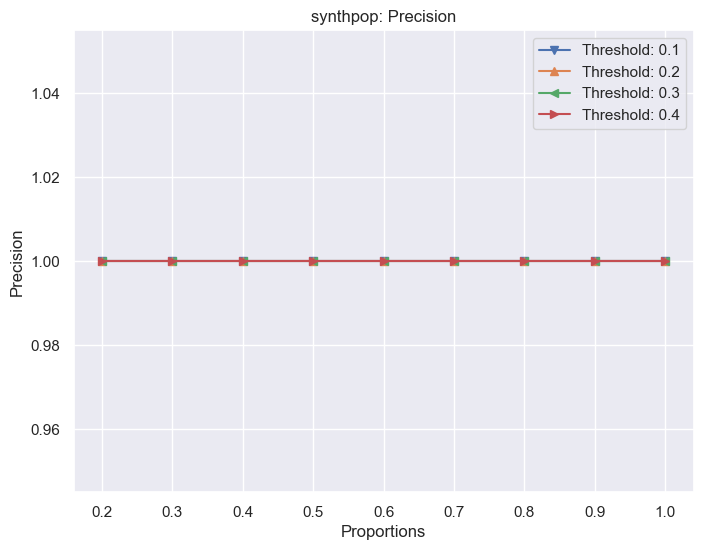

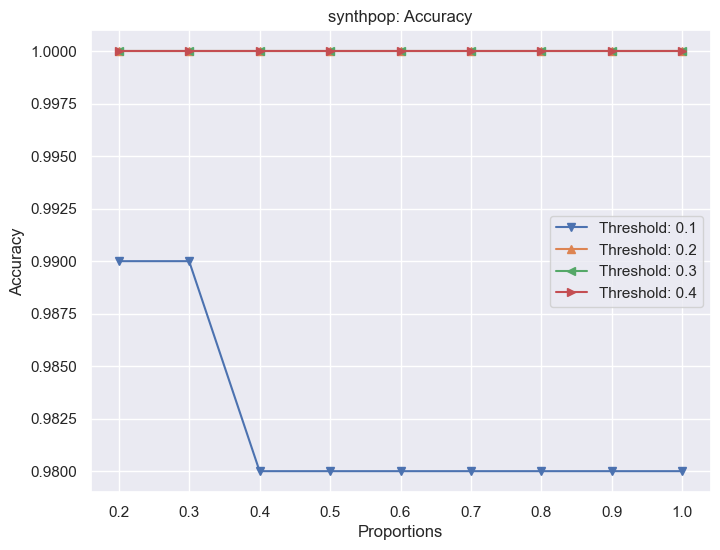

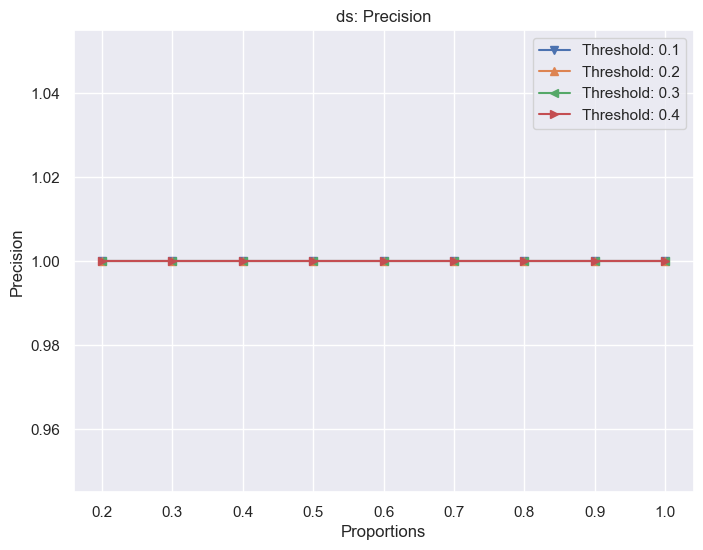

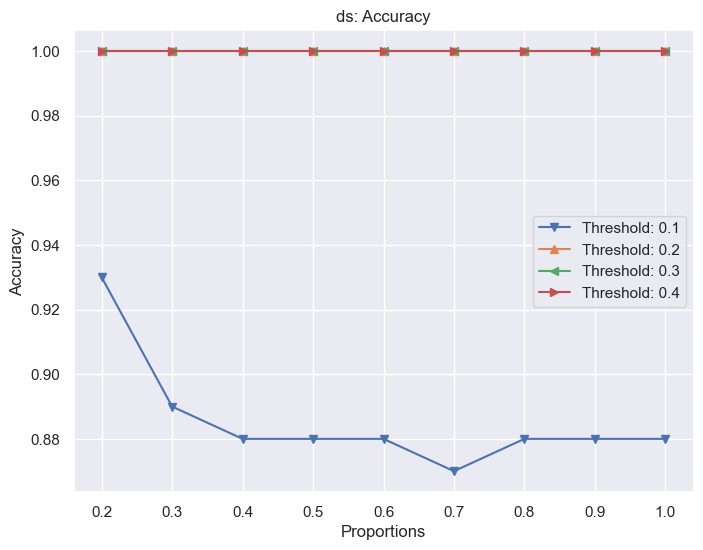

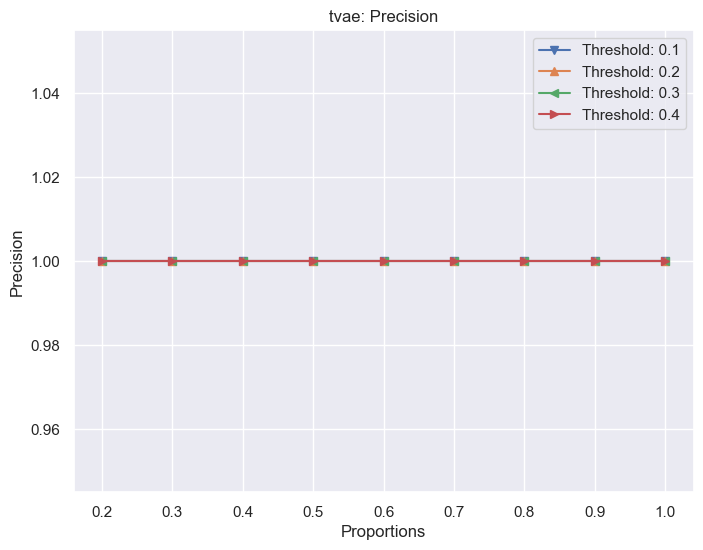

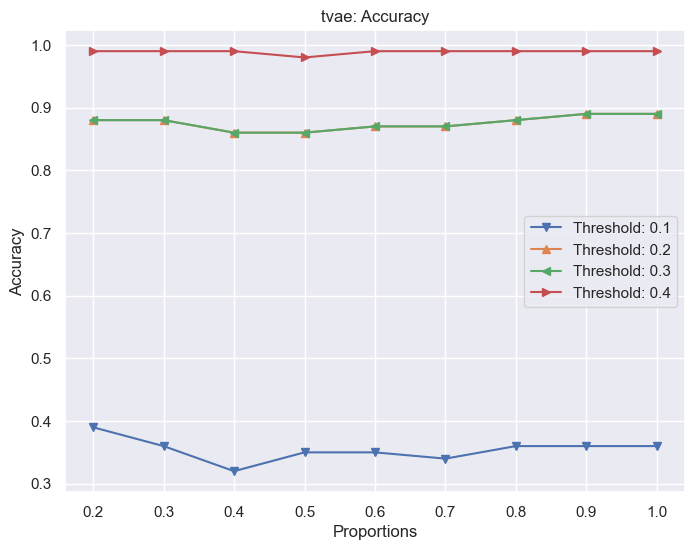

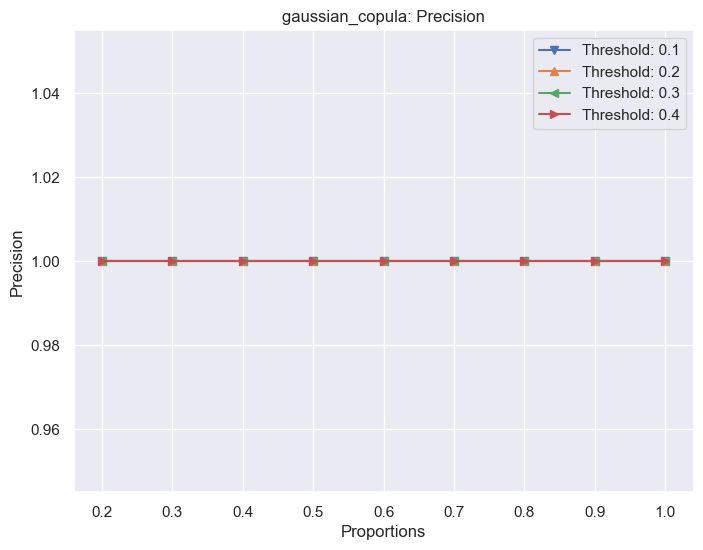

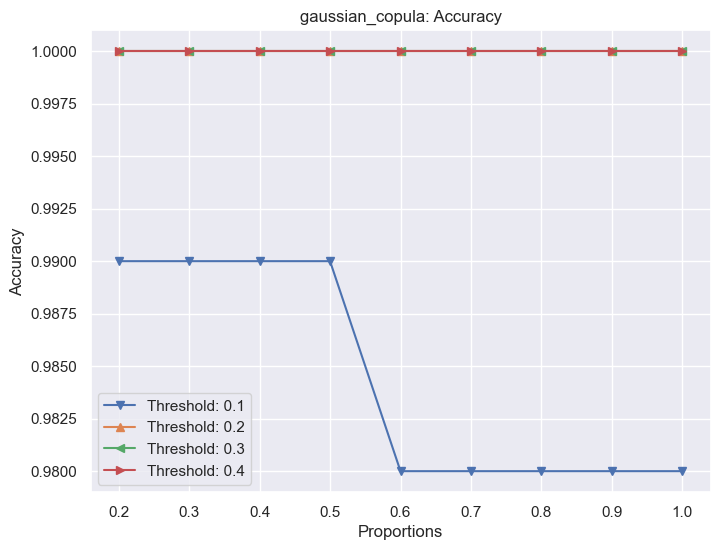

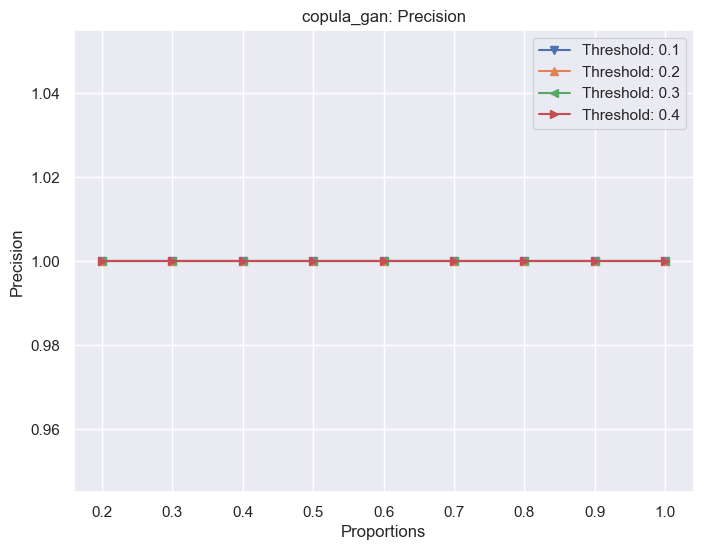

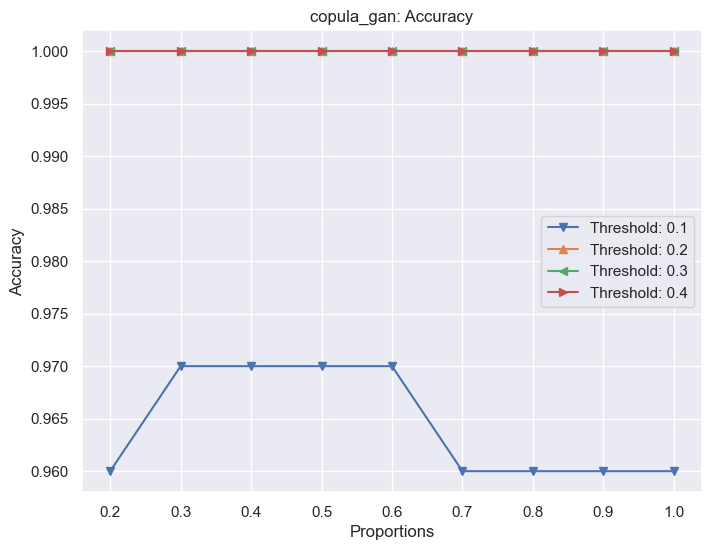

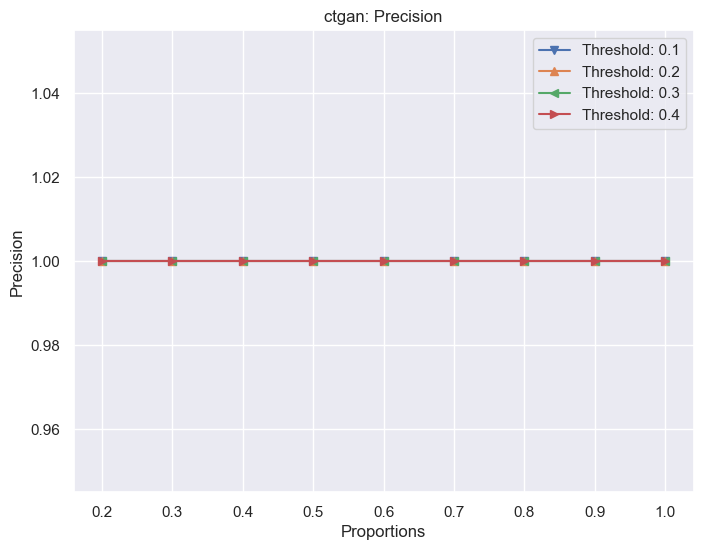

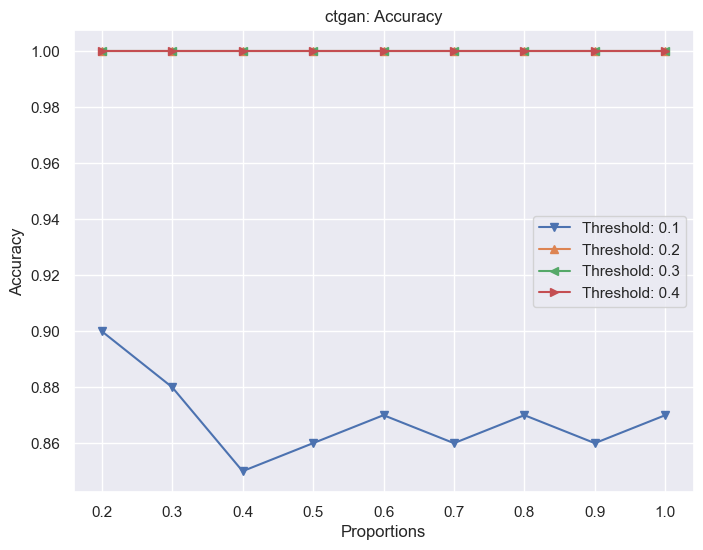

In [26]:
mia_results = {}
if (os.path.isfile("../data/results/plots/mia/2_fictional_students_performance/ds_mia_accuracy.png")):
    print("MIA results already exist.")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        mia_results[model_names[i]] = mia(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, save_plts=True)
